# Can Abnormality be Detected by Graph Neural Networks?
Ziwei Chai , Siqi You , Yang Yang , Shiliang Pu , Jiarong Xu , Haoyang Cai and Weihao Jiang

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch.nn import Parameter
from torch_geometric.utils import remove_self_loops, get_laplacian
from numpy import polynomial
import math
import pickle
from copy import deepcopy
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, RocCurveDisplay, roc_curve, PrecisionRecallDisplay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Exploring the dataset (Elliptic)
Exploring the dataset gives a good intuition about what the future plans should be

In [27]:
df_classes = pd.read_csv("./dataset/elliptic_csv/elliptic_txs_classes.csv")
df_edges = pd.read_csv("./dataset/elliptic_csv/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("./dataset/elliptic_csv/elliptic_txs_features.csv", header=None)

In [28]:
df_classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,1
203767,158654197,unknown


In [29]:
df_edges

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [30]:
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [31]:
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
df_features.columns = ["txId","Time_step"] + tx_features + agg_features
df_features = pd.merge(df_features,df_classes,left_on="txId",right_on="txId",how='left')
df_features['class'] = df_features['class'].apply(lambda x: '0' if x == "unknown" else x)

In [32]:
df_features

,txId,Time_step,tx_feat_2,tx_feat_3,tx_feat_4,tx_feat_5,tx_feat_6,tx_feat_7,tx_feat_8,tx_feat_9,...,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,0
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,0
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,0


<BarContainer object of 3 artists>

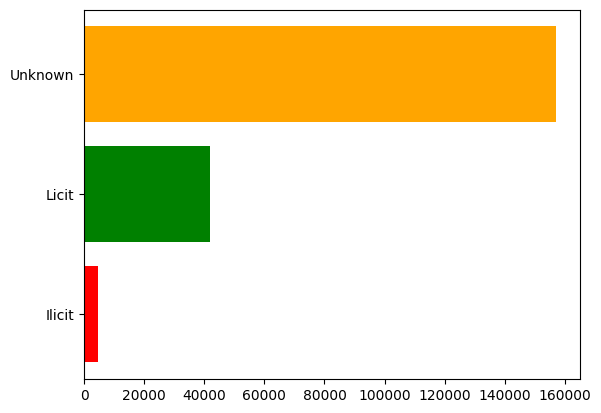

In [33]:
group_class = df_classes.groupby('class').count()
plt.barh(['Ilicit', 'Licit', 'Unknown'], group_class['txId'].values, color=['r', 'g', 'orange'] )

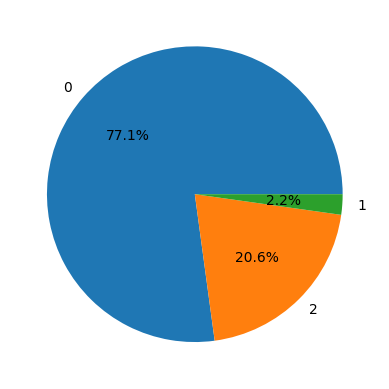

In [34]:
risk_counts = df_features['class'].value_counts()
plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%')
plt.show()

Text(0.5, 1.0, 'Number of transactions by Time step')

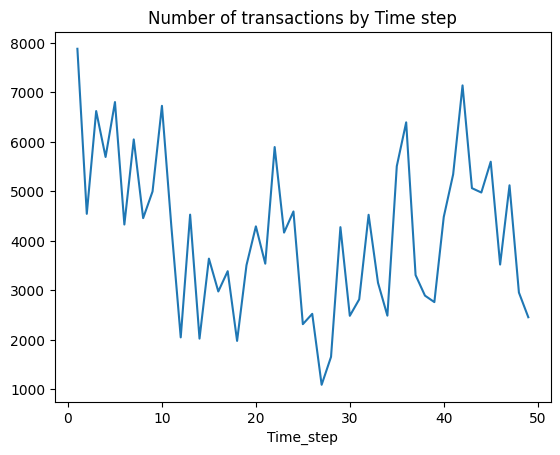

In [35]:
group_feature = df_features.groupby('Time_step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

In [36]:
df_class_feature = pd.merge(df_classes, df_features )

In [37]:
group_class_feature = df_features.groupby(['Time_step', 'class']).count()
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})

In [38]:
group_class_feature.head()

,Time_step,class,count
0,1,0,5733
1,1,1,17
2,1,2,2130
3,2,0,3427
4,2,1,18


/home/eshragm/AMNet/.venv/lib64/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/eshragm/AMNet/.venv/lib64/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/eshragm/AMNet/.venv/lib64/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/eshragm/AMNet/.venv/lib64/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence

<Axes: xlabel='Time_step', ylabel='count'>

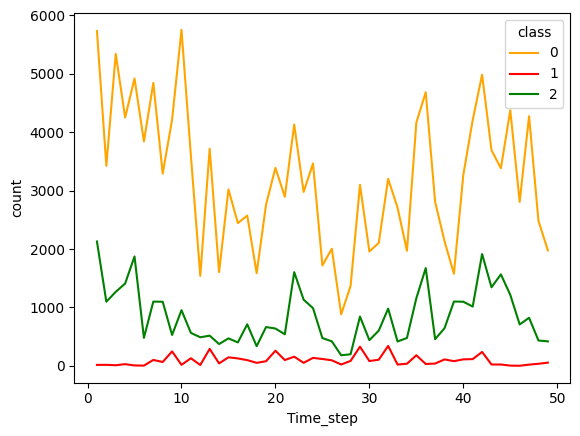

In [39]:
sns.lineplot(x='Time_step', y='count', hue='class', data = group_class_feature, palette=['orange', 'r', 'g'] )

Text(0.5, 0, 'Time_step')

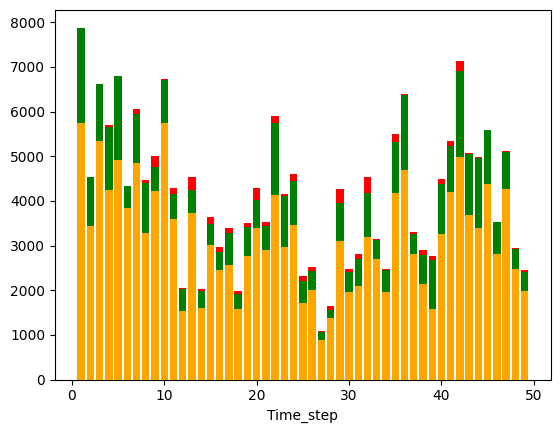

In [40]:
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == '0' ]

p1 = plt.bar(class3['Time_step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time_step'], class2['count'], color='g', bottom=class3['count'])

p3 = plt.bar(class1['Time_step'], class1['count'], color='r', bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time_step')

In [41]:
bad_ids = df_features[(df_features['Time_step'] == 32) & ((df_features['class'] == '1'))]['txId']
short_edges = df_edges[df_edges['txId1'].isin(bad_ids)]
graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
pos = nx.spring_layout(graph)

edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='blue'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text=[]
for node in graph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Transaction Type',
            xanchor='left',
            titleside='right',
            tickmode='array',
            tickvals=[0,1,2],
            ticktext=['Unknown','Illicit','Licit']
        ),
        line_width=2))
node_trace.text=node_text
node_trace.marker.color = pd.to_numeric(df_features[df_features['txId'].isin(list(graph.nodes()))]['class'])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title="Illicit Transactions",
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=True,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [42]:
good_ids = df_features[(df_features['Time_step'] == 32) & ((df_features['class'] == '2'))]['txId']
short_edges = df_edges[df_edges['txId1'].isin(good_ids)]
graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
pos = nx.spring_layout(graph)

edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='blue'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text=[]
for node in graph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Transaction Type',
            xanchor='left',
            titleside='right',
            tickmode='array',
            tickvals=[0,1,2],
            ticktext=['Unknown','Illicit','Licit']
        ),
        line_width=2))
node_trace.text=node_text
node_trace.marker.color = pd.to_numeric(df_features[df_features['txId'].isin(graph.nodes())]['class'])

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                title="Licit Transactions",
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=True,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

### Utils

Useful functions for training, evaluating and plotting the ROC and PR curves

In [2]:
def Bernstein(de, i):
    coefficients = [0, ] * i + [math.comb(de, i)]
    first_term = polynomial.polynomial.Polynomial(coefficients)
    second_term = polynomial.polynomial.Polynomial([1, -1]) ** (de - i)
    return first_term * second_term

@torch.no_grad()
def evaluate(model, x, y, edge_index, test_index):
    model.eval()
    y_pred = model.forward(x, edge_index)
    y_pred = F.softmax(y_pred, dim=1)[:, 1]
    model.train()
    y_test = y[test_index].cpu().numpy()
    y_pred = y_pred[test_index].cpu().numpy()
    auc_roc, auc_pr  = aucPerformance(y_test, y_pred)
    return auc_roc, auc_pr

def aucPerformance(y_true, y_pred):
    roc_auc = roc_auc_score(y_true.flatten(), y_pred.flatten())
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall, precision)
    return roc_auc, auc_pr

@torch.no_grad()
def plot_(model, x, y, edge_index, test_index):
    model.eval()
    y_pred_scores = model.forward(x, edge_index)
    y_pred = F.softmax(y_pred_scores, dim=1)[:, 1]
    model.train()
    y_test = y[test_index].cpu().numpy()
    y_pred = y_pred[test_index].cpu().numpy()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    display_pr = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    display_pr.figure_.savefig('./pr.jpg')
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display_roc.plot()
    display_roc.figure_.savefig('./roc.jpg')


### Graph Convolution Layer

In [3]:
class Conv(MessagePassing):
    def __init__(self, hid_channels, K):
        super().__init__()
        self.K = K
        self.in_features = hid_channels
        self.out_features = hid_channels
        self.weight = Parameter(torch.Tensor(K + 1, 1))
        self.bias = Parameter(torch.Tensor(hid_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.fill_(0)
        torch.nn.init.zeros_(self.weight)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def __norm__(self, edge_index, num_nodes, e_weight, l_max, dtype=None):
        edge_index, e_weight = remove_self_loops(edge_index, e_weight)
        edge_index, e_weight = get_laplacian(edge_index, e_weight, 'sym', dtype, num_nodes)

        e_weight = e_weight / l_max
        e_weight.masked_fill_(e_weight == float('inf'), 0)
        return edge_index, e_weight

    def forward(self, x, edge_index, e_weight=None, l_max=None):
        if l_max is None:
            l_max = torch.tensor(2.0, dtype=x.dtype, device=x.device)
        if not isinstance(l_max, torch.Tensor):
            l_max = torch.tensor(l_max, dtype=x.dtype, device=x.device)

        edge_index, norm = self.__norm__(edge_index, x.size(self.node_dim), e_weight, l_max, dtype=x.dtype)

        bx = [x]
        b_next = x

        for _ in range(self.K):
            b_next = self.propagate(edge_index, x=b_next, norm=norm, size=None)
            bx.append(b_next)

        b_coeffs = []
        for i in range(self.K + 1):
            b_coeffs.append(Bernstein(self.K, i).coef)
        
        weight = torch.sigmoid(self.weight)

        result = torch.zeros_like(x)
        for k in range(0, self.K + 1):
            coeff = b_coeffs[k]
            basis = bx[0] * coeff[0]
            for i in range(1, self.K + 1):
                basis += bx[i] * coeff[i]
            result += basis * weight[k]
        return result

### AMNet

In [4]:
class AMNet(nn.Module):
    def __init__(self, in_features, out_features, num_classes, K, num_filters):
        super().__init__()
        self.linear_transform_in = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU(), nn.Linear(out_features, out_features))
        self.K = K
        self.filters = nn.ModuleList([Conv(out_features, K) for _ in range(num_filters)])
        self.num_filters = num_filters
        self.W_f = nn.Sequential(nn.Linear(out_features, out_features), nn.Tanh())
        self.W_x = nn.Sequential(nn.Linear(out_features, out_features), nn.Tanh())
        self.linear_cls_out = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(out_features, num_classes)
        )

        self.attn = list(self.W_x.parameters()) + (list(self.W_f.parameters()))
        self.lin = list(self.linear_transform_in.parameters()) + list(self.linear_cls_out.parameters())
        self.reset_parameters()

    def forward(self, x, edge_index, label=None):
        x = self.linear_transform_in(x)
        h_list = []
        for i, _filter in enumerate(self.filters):
            h = _filter(x, edge_index)
            h_list.append(h)

        _filters = torch.stack(h_list, dim=1)
        x_proj = self.W_x(x).unsqueeze(-1)

        score = F.softmax(torch.bmm(self.W_f(_filters), x_proj), dim=1)

        out = _filters[:, 0, :] * score[:, 0]
        for i in range(1, self.num_filters):
            out += _filters[:, i, :] * score[:, i]

        y_pred = self.linear_cls_out(out)
        margin_loss = 0.

        if self.training:
            abnormal_train, normal_train = label
            normal_bias = torch.mean(torch.clamp(score[normal_train][:, 1] - score[normal_train][:, 0], -0.))
            abnormal_bias = torch.mean(torch.clamp(score[abnormal_train][:, 0] - score[abnormal_train][:, 1], -0.))
            margin_loss = abnormal_bias + normal_bias

        if self.training:
            return y_pred, margin_loss
        else:
            return y_pred
    
    def reset_parameters(self):
        pass

### Training on Elliptic dataset

In [112]:
model_config = {
    'K': 2,
    'M': 4,
    'out_features': 1024,
    'lr_f': 5e-2,
    'lr': 1e-5,
    'weight_decay': 1e-5,
    'beta': .5,
    'epochs': 2000
}

auc_roc_list = []
auc_pr_list = []
auc_pr_best = 0
best_model = None

for i in range(10):
    dataset = pickle.load(open(f'./dataset/elliptic/elliptic.dat', 'rb')).to(device)

    model = AMNet(in_features=dataset.x.shape[1], out_features=model_config['out_features'], num_classes=2, K=model_config['M'], num_filters=model_config['K'])
    model.to(device)

    optimizer = torch.optim.Adam(
        [
            {'params':model.filters.parameters(), 'lr':model_config['lr_f']},
            {'params':model.lin, 'lr':model_config['lr'], 'lr':model_config['lr'], 'weight_decay': model_config['weight_decay']},
            {'params':model.attn, 'lr':model_config['lr'], 'lr':model_config['lr'], 'weight_decay': model_config['weight_decay']},
        ]
    )

    weights = torch.Tensor([1., 1.])
    criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    abnormal = (dataset.y == 1)
    normal = (dataset.y == 0)
    labels = (abnormal, normal)

    auc_roc_best = 0
    auc_roc_test_epoch = 0
    auc_pr_test_epoch = 0


    for epoch in range(model_config['epochs']):
        abnormal, normal = labels
        model.train()
        optimizer.zero_grad()
        output, bias_loss = model(dataset.x, dataset.edge_index, label=(dataset.train_mask & abnormal, dataset.train_mask & normal))
        loss_train = criterion(output[dataset.train_mask], dataset.y[dataset.train_mask]) + bias_loss * model_config['beta']
        loss_train.backward()
        optimizer.step()
        loss = loss_train.item()
        auc_roc_val, auc_pr_val = evaluate(model, dataset.x, dataset.y, dataset.edge_index, dataset.val_mask)
        if (epoch + 1) % 300 == 0 or epoch == 0:
            print(f'Epoch:{(epoch + 1):d}\tLoss:{loss:.4f}\tAUC-ROC:{auc_roc_val:.4f}\tAUC-PR:{auc_pr_val:.4f}\tBest AUC-ROC:{auc_roc_test_epoch:.4f}\tBest AUC-PR:{auc_pr_test_epoch:.4f}')

        if auc_pr_val >= auc_pr_best:
            auc_pr_best = auc_pr_val
            auc_roc_best = auc_roc_val
            auc_roc_test_epoch, auc_pr_test_epoch = evaluate(model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)
            best_model = deepcopy(model)

    auc_roc_test, auc_pr_test = evaluate(best_model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)
    print(auc_roc_test, auc_pr_test)
    auc_roc_list.append(auc_roc_test)
    auc_pr_list.append(auc_pr_test)

print(f"AUC ROC Mean:{np.mean(auc_roc_list):.5f}\tStd:{np.std(auc_roc_list):.5f}\tAUC PR Mean:{np.mean(auc_pr_list):.5f}\tStd:{np.std(auc_pr_list):.5f}")

Epoch:1	Loss:0.6918	AUC-ROC:0.5941	AUC-PR:0.1806	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:300	Loss:0.1721	AUC-ROC:0.8074	AUC-PR:0.5976	Best AUC-ROC:0.8509	Best AUC-PR:0.6505
Epoch:600	Loss:0.1357	AUC-ROC:0.8142	AUC-PR:0.6217	Best AUC-ROC:0.8680	Best AUC-PR:0.6945
Epoch:900	Loss:0.1138	AUC-ROC:0.8254	AUC-PR:0.6399	Best AUC-ROC:0.8796	Best AUC-PR:0.7238
Epoch:1200	Loss:0.0998	AUC-ROC:0.8367	AUC-PR:0.6599	Best AUC-ROC:0.8879	Best AUC-PR:0.7389
Epoch:1500	Loss:0.0901	AUC-ROC:0.8464	AUC-PR:0.6785	Best AUC-ROC:0.8925	Best AUC-PR:0.7452
Epoch:1800	Loss:0.0827	AUC-ROC:0.8501	AUC-PR:0.6833	Best AUC-ROC:0.8929	Best AUC-PR:0.7297
0.8923241193311588 0.7064075011964228
Epoch:1	Loss:0.6273	AUC-ROC:0.7817	AUC-PR:0.3192	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:300	Loss:0.1700	AUC-ROC:0.8057	AUC-PR:0.5982	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:600	Loss:0.1342	AUC-ROC:0.8122	AUC-PR:0.6272	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:900	Loss:0.1119	AUC-ROC:0.8233	AUC-PR:0.6475	Best AUC-ROC

In [113]:
auc_pr_list

[0.7064075011964228,
 0.7064075011964228,
 0.748694398408829,
 0.7486944045371899,
 0.7486943984088289,
 0.7486944045371899,
 0.7486944106702986,
 0.7486944106702986,
 0.7486944045371899,
 0.748694398408829]

In [121]:
auc_roc_list

[0.8923241193311588,
 0.8923241193311588,
 0.899213428146819,
 0.899213457766407,
 0.8992134281468191,
 0.8992134577664072,
 0.899213487385995,
 0.8992134873859949,
 0.899213457766407,
 0.899213428146819]

In [115]:
auc_roc_test, auc_pr_test = evaluate(best_model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)

In [116]:
auc_roc_test

0.899213487385995

In [117]:
auc_pr_test

0.7486944106702986

In [119]:
torch.save(best_model.state_dict(), './model_state.pt')

In [120]:
torch.save(best_model, './model.pt')

### Plotting the ROC and PR curves

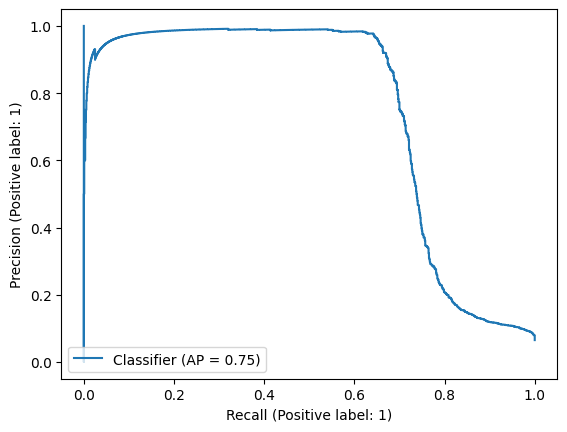

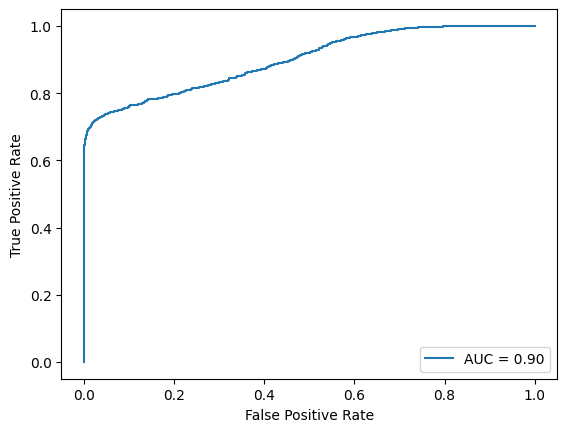

In [147]:
plot_(best_model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)

### Training on Yelp dataset

In [6]:
model_config = {
    'K': 2,
    'M': 5,
    'out_features': 64,
    'lr_f': 5e-2,
    'lr': 5e-4,
    'weight_decay': 1e-5,
    'beta': 1.,
    'epochs': 2000,
}

auc_roc_list = []
auc_pr_list = []
auc_pr_best = 0
best_model = None

for i in range(10):
    dataset = pickle.load(open(f'./dataset/yelp/yelp.dat', 'rb')).to(device)

    model = AMNet(in_features=dataset.x.shape[1], out_features=model_config['out_features'], num_classes=2, K=model_config['M'], num_filters=model_config['K'])
    model.to(device)

    optimizer = torch.optim.Adam(
        [
            {'params':model.filters.parameters(), 'lr':model_config['lr_f']},
            {'params':model.lin, 'lr':model_config['lr'], 'lr':model_config['lr'], 'weight_decay': model_config['weight_decay']},
            {'params':model.attn, 'lr':model_config['lr'], 'lr':model_config['lr'], 'weight_decay': model_config['weight_decay']},
        ]
    )

    weights = torch.Tensor([1., 1.])
    criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    abnormal = (dataset.y == 1)
    normal = (dataset.y == 0)
    labels = (abnormal, normal)

    auc_roc_best = 0
    auc_roc_test_epoch = 0
    auc_pr_test_epoch = 0


    for epoch in range(model_config['epochs']):
        abnormal, normal = labels
        model.train()
        optimizer.zero_grad()
        output, bias_loss = model(dataset.x, dataset.edge_index, label=(dataset.train_mask & abnormal, dataset.train_mask & normal))
        loss_train = criterion(output[dataset.train_mask], dataset.y[dataset.train_mask]) + bias_loss * model_config['beta']
        loss_train.backward()
        optimizer.step()
        loss = loss_train.item()
        auc_roc_val, auc_pr_val = evaluate(model, dataset.x, dataset.y, dataset.edge_index, dataset.val_mask)
        if (epoch + 1) % 300 == 0 or epoch == 0:
            print(f'Epoch:{(epoch + 1):d}\tLoss:{loss:.4f}\tAUC-ROC:{auc_roc_val:.4f}\tAUC-PR:{auc_pr_val:.4f}\tBest AUC-ROC:{auc_roc_test_epoch:.4f}\tBest AUC-PR:{auc_pr_test_epoch:.4f}')

        if auc_pr_val >= auc_pr_best:
            auc_pr_best = auc_pr_val
            auc_roc_best = auc_roc_val
            auc_roc_test_epoch, auc_pr_test_epoch = evaluate(model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)
            best_model = deepcopy(model)

    auc_roc_test, auc_pr_test = evaluate(best_model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)
    print(auc_roc_test, auc_pr_test)
    auc_roc_list.append(auc_roc_test)
    auc_pr_list.append(auc_pr_test)

print(f"AUC ROC Mean:{np.mean(auc_roc_list):.5f}\tStd:{np.std(auc_roc_list):.5f}\tAUC PR Mean:{np.mean(auc_pr_list):.5f}\tStd:{np.std(auc_pr_list):.5f}")

Epoch:1	Loss:0.6774	AUC-ROC:0.4940	AUC-PR:0.1465	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:300	Loss:0.3484	AUC-ROC:0.7890	AUC-PR:0.4211	Best AUC-ROC:0.7756	Best AUC-PR:0.4158
Epoch:600	Loss:0.3072	AUC-ROC:0.8406	AUC-PR:0.5192	Best AUC-ROC:0.8281	Best AUC-PR:0.5222
Epoch:900	Loss:0.2910	AUC-ROC:0.8549	AUC-PR:0.5520	Best AUC-ROC:0.8382	Best AUC-PR:0.5423
Epoch:1200	Loss:0.2810	AUC-ROC:0.8590	AUC-PR:0.5656	Best AUC-ROC:0.8424	Best AUC-PR:0.5503
Epoch:1500	Loss:0.2758	AUC-ROC:0.8611	AUC-PR:0.5703	Best AUC-ROC:0.8430	Best AUC-PR:0.5551
Epoch:1800	Loss:0.2721	AUC-ROC:0.8610	AUC-PR:0.5741	Best AUC-ROC:0.8440	Best AUC-PR:0.5604
0.8440604094677987 0.5614969246035766
Epoch:1	Loss:0.6199	AUC-ROC:0.4925	AUC-PR:0.1422	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:300	Loss:0.3397	AUC-ROC:0.8011	AUC-PR:0.4362	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:600	Loss:0.2990	AUC-ROC:0.8409	AUC-PR:0.5170	Best AUC-ROC:0.0000	Best AUC-PR:0.0000
Epoch:900	Loss:0.2814	AUC-ROC:0.8523	AUC-PR:0.5474	Best AUC-ROC

In [7]:
auc_pr_list

[0.5614969246035766,
 0.5614968767674274,
 0.5614968965333232,
 0.5614969246035767,
 0.5614969329183409,
 0.5614969329183409,
 0.5614968767674273,
 0.5614969246035766,
 0.5614969329183409,
 0.5614968965333232]

In [8]:
auc_roc_list

[0.8440604094677987,
 0.8440603141185534,
 0.8440603617931761,
 0.8440604094677986,
 0.8440604094677986,
 0.8440604094677987,
 0.8440603141185535,
 0.8440604094677986,
 0.8440604094677986,
 0.8440603617931761]

In [9]:
auc_roc_test, auc_pr_test = evaluate(best_model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)

In [10]:
auc_roc_test

0.844060361793176

In [11]:
auc_pr_test

0.5614969048376809

### Plotting the ROC and PR curves

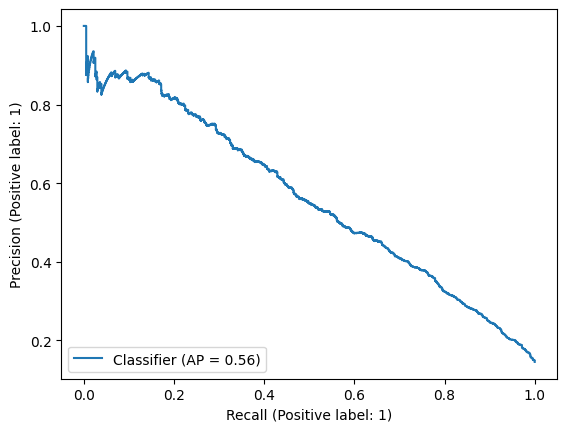

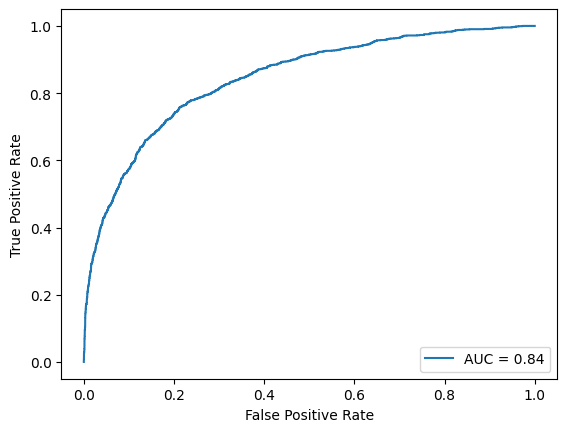

In [12]:
plot_(best_model, dataset.x, dataset.y, dataset.edge_index, dataset.test_mask)